In [ ]:
!pip install -U sentence-transformers

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import pandas as pd
train_df = pd.read_csv("/content/drive/MyDrive/Mini-projects/MSRP/train.tsv", on_bad_lines='skip', sep="\t")
dev_df = pd.read_csv("/content/drive/MyDrive/Mini-projects/MSRP/dev.tsv", on_bad_lines='skip', sep="\t")

# Shape of the data
print(f"Total train samples : {train_df.shape[0]}")
print(f"Total dev samples: {dev_df.shape[0]}")

print(f"Sentence1: {train_df.loc[1, '#1 String']}")
print(f"Sentence2: {train_df.loc[1, '#2 String']}")
print(f"Similarity: {train_df.loc[1, 'Quality']}")

print("Number of missing values")
print(train_df.isnull().sum())
train_df.dropna(axis=0, inplace=True)

print("Number of missing values")
print(dev_df.isnull().sum())
dev_df.dropna(axis=0, inplace=True)

train_df

Total train samples : 3458
Total dev samples: 480
Sentence1: Yucaipa owned Dominick's before selling the chain to Safeway in 1998 for $2.5 billion.
Sentence2: Yucaipa bought Dominick's in 1995 for $693 million and sold it to Safeway for $1.8 billion in 1998.
Similarity: 0
Number of missing values
Quality       0
#1 ID         0
#2 ID         0
#1 String     0
#2 String    17
dtype: int64
Number of missing values
Quality      0
#1 ID        0
#2 ID        0
#1 String    0
#2 String    4
dtype: int64


,Quality,#1 ID,#2 ID,#1 String,#2 String
0,1,702876,702977,"Amrozi accused his brother, whom he called ""th...","Referring to him as only ""the witness"", Amrozi..."
1,0,2108705,2108831,Yucaipa owned Dominick's before selling the ch...,Yucaipa bought Dominick's in 1995 for $693 mil...
2,1,1330381,1330521,They had published an advertisement on the Int...,"On June 10, the ship's owners had published an..."
3,0,3344667,3344648,"Around 0335 GMT, Tab shares were up 19 cents, ...","Tab shares jumped 20 cents, or 4.6%, to set a ..."
4,1,1236820,1236712,"The stock rose $2.11, or about 11 percent, to ...",PG&E Corp. shares jumped $1.63 or 8 percent to...
...,...,...,...,...,...
3453,1,1466168,1466246,"During the flight, engineers misjudged the ext...","During the flight, engineers underestimated th..."
3454,0,2245085,2245118,The Web site is registered to Parson under his...,The t33kid.com site is registered to Parson at...
3455,1,3237867,3237902,"The woman, Mary Kathryn Miller, 55, was arrest...","Mary Kathryn Miller, 55, of 27 Devon Road, Dar..."
3456,0,2194711,2194792,The Hubble Space Telescope's newest picture of...,The pictures were taken late Tuesday and early...


In [ ]:
from sentence_transformers import InputExample

#As we want to get symmetric scores, i.e. CrossEncoder(A,B) = CrossEncoder(B,A), we pass both combinations to the train set
train_samples = []
for i, row in train_df.iterrows():
  train_samples.append(InputExample(texts=[row["#1 String"], row["#2 String"]], label=int(row["Quality"])))
  train_samples.append(InputExample(texts=[row["#2 String"], row["#1 String"]], label=int(row["Quality"])))

dev_samples = [InputExample(texts=[row["#1 String"], row["#2 String"]], label=int(row["Quality"])) for i, row in dev_df.iterrows()]

In [ ]:
import sys
sys.path.append("/content/drive/MyDrive/Mini-projects")
from f1evaluation import CEBinaryF1Evaluator

evaluator = CEBinaryF1Evaluator.from_input_examples(dev_samples, name='msrp-dev')

In [ ]:
from datetime import datetime
from sentence_transformers import CrossEncoder

#Configuration
train_batch_size = 16
num_epochs = 50
evaluation_steps = 5000

model_name = 'cross-encoder/stsb-roberta-base'

# Save path of the model
model_save_path = '/content/drive/MyDrive/Mini-projects/output/training_paraphrases_'+model_name.replace("/", "-")

#We use stsb-roberta-base with a single label, i.e., it will output a value between 0 and 1 indicating the similarity of the two sentences
model = CrossEncoder(model_name, num_labels=1)

config.json:   0%|          | 0.00/608 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/499M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/142 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/899k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/772 [00:00<?, ?B/s]

In [ ]:
from torch.utils.data import DataLoader
import math

train_dataloader = DataLoader(train_samples, shuffle=True, batch_size=train_batch_size)

# Configure the training
warmup_steps = math.ceil(len(train_dataloader) * num_epochs * 0.1) #10% of train data for warm-up

In [ ]:
# Train the model
model.fit(train_dataloader=train_dataloader,
          evaluator=evaluator,
          epochs=num_epochs,
          evaluation_steps=evaluation_steps,
          warmup_steps=warmup_steps,
          output_path=model_save_path)

Epoch:   0%|          | 0/50 [00:00<?, ?it/s]

Iteration:   0%|          | 0/431 [00:00<?, ?it/s]

Iteration:   0%|          | 0/431 [00:00<?, ?it/s]

Iteration:   0%|          | 0/431 [00:00<?, ?it/s]

Iteration:   0%|          | 0/431 [00:00<?, ?it/s]

Iteration:   0%|          | 0/431 [00:00<?, ?it/s]

Iteration:   0%|          | 0/431 [00:00<?, ?it/s]

Iteration:   0%|          | 0/431 [00:00<?, ?it/s]

Iteration:   0%|          | 0/431 [00:00<?, ?it/s]

Iteration:   0%|          | 0/431 [00:00<?, ?it/s]

Iteration:   0%|          | 0/431 [00:00<?, ?it/s]

Iteration:   0%|          | 0/431 [00:00<?, ?it/s]

Iteration:   0%|          | 0/431 [00:00<?, ?it/s]

Iteration:   0%|          | 0/431 [00:00<?, ?it/s]

Iteration:   0%|          | 0/431 [00:00<?, ?it/s]

Iteration:   0%|          | 0/431 [00:00<?, ?it/s]

Iteration:   0%|          | 0/431 [00:00<?, ?it/s]

Iteration:   0%|          | 0/431 [00:00<?, ?it/s]

Iteration:   0%|          | 0/431 [00:00<?, ?it/s]

Iteration:   0%|          | 0/431 [00:00<?, ?it/s]

Iteration:   0%|          | 0/431 [00:00<?, ?it/s]

Iteration:   0%|          | 0/431 [00:00<?, ?it/s]

Iteration:   0%|          | 0/431 [00:00<?, ?it/s]

Iteration:   0%|          | 0/431 [00:00<?, ?it/s]

Iteration:   0%|          | 0/431 [00:00<?, ?it/s]

Iteration:   0%|          | 0/431 [00:00<?, ?it/s]

Iteration:   0%|          | 0/431 [00:00<?, ?it/s]

Iteration:   0%|          | 0/431 [00:00<?, ?it/s]

Iteration:   0%|          | 0/431 [00:00<?, ?it/s]

Iteration:   0%|          | 0/431 [00:00<?, ?it/s]

Iteration:   0%|          | 0/431 [00:00<?, ?it/s]

Iteration:   0%|          | 0/431 [00:00<?, ?it/s]

Iteration:   0%|          | 0/431 [00:00<?, ?it/s]

Iteration:   0%|          | 0/431 [00:00<?, ?it/s]

Iteration:   0%|          | 0/431 [00:00<?, ?it/s]

Iteration:   0%|          | 0/431 [00:00<?, ?it/s]

Iteration:   0%|          | 0/431 [00:00<?, ?it/s]

Iteration:   0%|          | 0/431 [00:00<?, ?it/s]

Iteration:   0%|          | 0/431 [00:00<?, ?it/s]

Iteration:   0%|          | 0/431 [00:00<?, ?it/s]

Iteration:   0%|          | 0/431 [00:00<?, ?it/s]

Iteration:   0%|          | 0/431 [00:00<?, ?it/s]

Iteration:   0%|          | 0/431 [00:00<?, ?it/s]

Iteration:   0%|          | 0/431 [00:00<?, ?it/s]

Iteration:   0%|          | 0/431 [00:00<?, ?it/s]

Iteration:   0%|          | 0/431 [00:00<?, ?it/s]

Iteration:   0%|          | 0/431 [00:00<?, ?it/s]

Iteration:   0%|          | 0/431 [00:00<?, ?it/s]

Iteration:   0%|          | 0/431 [00:00<?, ?it/s]

Iteration:   0%|          | 0/431 [00:00<?, ?it/s]

Iteration:   0%|          | 0/431 [00:00<?, ?it/s]

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

import pandas as pd
result = pd.read_csv("/content/drive/MyDrive/Mini-projects/output/training_paraphrases_cross-encoder-stsb-roberta-base/CEBinaryClassificationEvaluator_msrp-dev_results.csv")
result

Mounted at /content/drive


,epoch,steps,Accuracy,Accuracy_Threshold,F1,F1_Threshold,Precision,Recall,Average_Precision
0,0,-1,0.865546,0.495676,0.903323,0.495676,0.900602,0.906061,0.973254
1,1,-1,0.911765,0.487022,0.937313,0.467288,0.923529,0.951515,0.984149
2,2,-1,0.907563,0.219653,0.935673,0.056965,0.903955,0.969697,0.983872
3,3,-1,0.909664,0.819265,0.935532,0.819265,0.925816,0.945455,0.984430
4,4,-1,0.909664,0.014002,0.935917,0.014002,0.920821,0.951515,0.977290
5,5,-1,0.913866,0.780111,0.938346,0.780111,0.931343,0.945455,0.980425
6,6,-1,0.913866,0.003099,0.938897,0.003099,0.923754,0.954545,0.974062
7,7,-1,0.915966,0.996622,0.939759,0.996622,0.934132,0.945455,0.980113
8,8,-1,0.913866,0.176832,0.937595,0.176832,0.941896,0.933333,0.982709
9,9,-1,0.905462,0.999444,0.931921,0.999330,0.930514,0.933333,0.978146


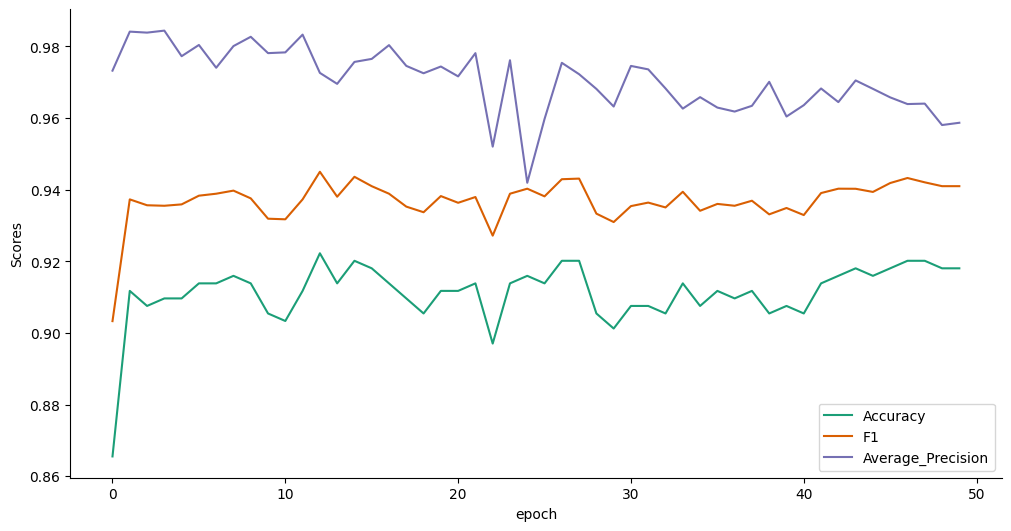

In [ ]:
from matplotlib import pyplot as plt
import seaborn as sns
def _plot_series(series, series_name, series_index=0):
  from matplotlib import pyplot as plt
  import seaborn as sns
  palette = list(sns.palettes.mpl_palette('Dark2'))
  xs = series['epoch']
  ys = series[series_name]
  plt.plot(xs, ys, label=series_name, color=palette[series_index % len(palette)])

fig, ax = plt.subplots(figsize=(10, 5.2), layout='constrained')
df_sorted = result.sort_values('epoch', ascending=True)
_plot_series(df_sorted, "Accuracy", 0)
_plot_series(df_sorted, "F1", 1)
_plot_series(df_sorted, "Average_Precision", 2)
sns.despine(fig=fig, ax=ax)
plt.xlabel('epoch')
_ = plt.ylabel('Scores')

plt.legend()
plt.show()